# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [-9, -7]
regularization_strengths = [5, 7]

results = {}
best_val = -1
best_svm = None

for _ in np.arange(50):
    i = 10 ** np.random.uniform(low=learning_rates[0], high=learning_rates[1])
    j = 10 ** np.random.uniform(low=regularization_strengths[0], high=regularization_strengths[1])
    
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=i, reg=j, 
              num_iters=500, verbose=False)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    accuracy = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
    
    results[(i, j)] = accuracy
    
    if accuracy[1] > best_val:
        best_val = accuracy[1]

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.351903e-09 reg 3.640846e+05 train accuracy: 0.090898 val accuracy: 0.097000
lr 1.377683e-09 reg 1.311876e+06 train accuracy: 0.093347 val accuracy: 0.106000
lr 1.578317e-09 reg 7.898379e+05 train accuracy: 0.096571 val accuracy: 0.105000
lr 1.681934e-09 reg 3.898770e+05 train accuracy: 0.111020 val accuracy: 0.115000
lr 1.817105e-09 reg 1.839318e+05 train accuracy: 0.098755 val accuracy: 0.099000
lr 1.853345e-09 reg 4.239745e+05 train accuracy: 0.098918 val accuracy: 0.091000
lr 2.020276e-09 reg 5.165705e+06 train accuracy: 0.085816 val accuracy: 0.088000
lr 2.057186e-09 reg 2.613527e+06 train accuracy: 0.096694 val accuracy: 0.108000
lr 2.131929e-09 reg 3.449305e+06 train accuracy: 0.116959 val accuracy: 0.107000
lr 2.159976e-09 reg 2.189374e+06 train accuracy: 0.107837 val accuracy: 0.092000
lr 2.928315e-09 reg 1.429740e+06 train accuracy: 0.100327 val accuracy: 0.100000
lr 2.931493e-09 reg 2.505679e+06 train accuracy: 0.095082 val accuracy: 0.106000
lr 3.114981e-09 reg 2.710443

In [7]:
# Get the best hyperparameter from result
best_lr = 0.0
best_reg = 0.0

for lr, reg in results:
    if results[(lr, reg)][1] == best_val:
        best_lr = lr
        best_reg = reg
        break
        
print 'Best learning rate: %f, best regularisation strength: %f' % (best_lr, best_reg, )

Best learning rate: 0.000000, best regularisation strength: 1055675.439204


iteration 0 / 2000: loss 820.123936
iteration 100 / 2000: loss 17.002393
iteration 200 / 2000: loss 9.078919
iteration 300 / 2000: loss 9.000740
iteration 400 / 2000: loss 8.999976
iteration 500 / 2000: loss 8.999967
iteration 600 / 2000: loss 8.999970
iteration 700 / 2000: loss 8.999967
iteration 800 / 2000: loss 8.999965
iteration 900 / 2000: loss 8.999970
iteration 1000 / 2000: loss 8.999972
iteration 1100 / 2000: loss 8.999964
iteration 1200 / 2000: loss 8.999968
iteration 1300 / 2000: loss 8.999971
iteration 1400 / 2000: loss 8.999969
iteration 1500 / 2000: loss 8.999967
iteration 1600 / 2000: loss 8.999971
iteration 1700 / 2000: loss 8.999968
iteration 1800 / 2000: loss 8.999970
iteration 1900 / 2000: loss 8.999964


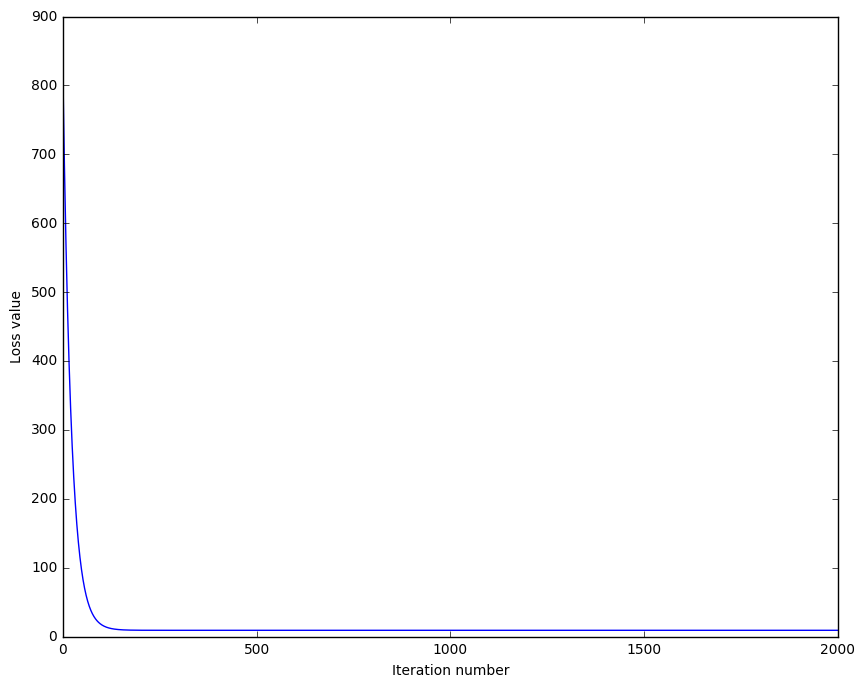

In [8]:
# Train the classifier with the best hyperparameters
best_svm = LinearSVM()
loss_hist = best_svm.train(X_train_feats, y_train, learning_rate=best_lr, reg=best_reg, 
                           num_iters=2000, verbose=True)

# plot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.415


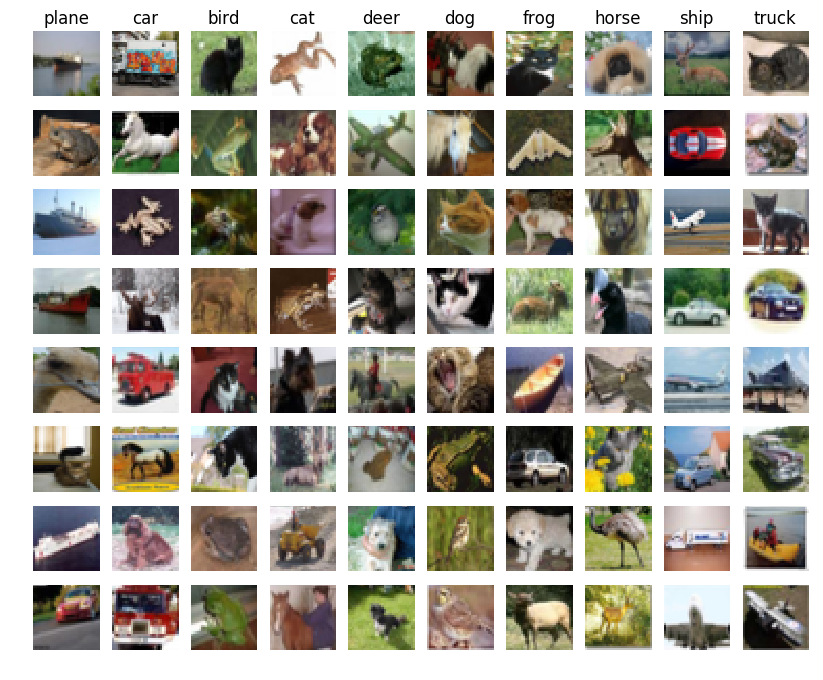

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
print X_train_feats.shape

(49000, 155)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 200
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

learning = [1e-5, 1]
regularization = [1e0, 1e4]
decay = [0.9, 1]

results = {}
best_val = -1

for _ in np.arange(0, 50):
    i = np.random.uniform(low=learning[0], high=learning[1])
    j = np.random.uniform(low=regularization[0], high=regularization[1])
    k = np.random.uniform(low=decay[0], high=decay[1])

    # Train the network
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=500, batch_size=200,
                      learning_rate=i, learning_rate_decay=k,
                      reg=j, verbose=False)

    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    
    results[(i, j, k)] = val_acc
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        
for i, j, k in results:
    print 'lr: %f, reg: %f, dec: %f -> %f' % (i, j, k, results[(i, j, k)])

In [23]:
print best_val

# Find the best learning rate and regularization strength
best_lr = 0.
best_reg = 0.
best_decay = 0.

for lr, reg, dec in sorted(results):
    if results[(lr, reg, dec)] == best_val:
        best_lr = lr
        best_reg = reg
        best_decay = dec
        break
        
print best_lr, best_decay, best_reg

stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
                       num_iters=2000, batch_size=400,
                       learning_rate=best_lr, learning_rate_decay=best_decay,
                       reg=best_reg, verbose=True)

0.107
0.000871479072444 0.930937309316 0.0910125679303
iteration 0 / 2000: loss 2.302702
iteration 100 / 2000: loss 2.302475
iteration 200 / 2000: loss 2.302590
iteration 300 / 2000: loss 2.302459
iteration 400 / 2000: loss 2.302579
iteration 500 / 2000: loss 2.302654
iteration 600 / 2000: loss 2.302253
iteration 700 / 2000: loss 2.302533
iteration 800 / 2000: loss 2.302543
iteration 900 / 2000: loss 2.302380
iteration 1000 / 2000: loss 2.302541
iteration 1100 / 2000: loss 2.302705
iteration 1200 / 2000: loss 2.302548
iteration 1300 / 2000: loss 2.302359
iteration 1400 / 2000: loss 2.302471
iteration 1500 / 2000: loss 2.302709
iteration 1600 / 2000: loss 2.302449
iteration 1700 / 2000: loss 2.302500
iteration 1800 / 2000: loss 2.302909
iteration 1900 / 2000: loss 2.302310


In [22]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.1


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!